# Network analysis using the origins and divisions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import json

In [2]:
# Loading data
recensement = pd.read_excel(io="../../1832_v4.xlsx", na_values=["·","?"])
classes_metiers = pd.read_excel(io="../../histoire urbaine digitale classification metiers.xlsx", sheet_name="data",  na_values="·")
classes_origines = pd.read_excel(io="../../histoire urbaine digitale classification origines.xlsx",  na_values="·")
rues = pd.read_csv("../../nom_rues_et_coor.csv", sep=",")

# Adding the 'chef_vocation_categorie' column
classes_metiers = classes_metiers.rename(columns={"JOB": "chef_vocation_norm_2"})
classes_metiers = classes_metiers.rename(columns={"CLASS": "chef_vocation_categorie"})
recensement = recensement.merge(classes_metiers, on="chef_vocation_norm_2", how="outer")

# Add a new column that corresponds to CLASSIFICATION in the classes_origines that is taken from matching ORIGINE and chef_origine_norm_2
merged_df = pd.merge(recensement, classes_origines, left_on='chef_origine_norm_2', right_on='ORIGINE', how='left')
recensement['class_origine'] = merged_df['CLASSIFICATION']

In [3]:
# Split the values on the '/' character
split_vals = recensement['chef_vocation_categorie'].str.split('/')

# Create a new dataframe from the split values
recensement = recensement.assign(chef_vocation_categorie=split_vals).explode('chef_vocation_categorie')

# Adding coordinates
correspondances = {
    "nom_rue": [
        "ale", 
        "etraz", 
        "rue du pre", 
        "chaucrau", 
        "st laurent", 
        "st pierre", 
        "st etienne", 
        "bourg", 
        "st francois", 
        "georgette",
    ],
    "nom_rue_norm_2": [
        "rue de l'ale",
        "rue d etraz",
        "rue du pre",
        "rue de chaucrau",
        "place de st laurent",
        "rue de st pierre",
        "st etienne",
        "rue de bourg",
        "place de st froncois",
        "chemin de georgette",
    ]
}
for index, row in tqdm(recensement.iterrows(), total=len(recensement), desc="Adding coordinates"):
    nom_rue = row["nom_rue_norm_2"]
    if type(nom_rue) == float: continue # if nom_rue is NaN
    if nom_rue in correspondances["nom_rue"]:
        index = correspondances["nom_rue"].index(nom_rue)
        nom_rue = correspondances["nom_rue_norm_2"][index]
        corresponding_streets = rues.query("Nom_rue == @nom_rue")
    else:
        corresponding_streets = rues.query("Nom_rue.str.contains(@nom_rue)")
    occurences = len(corresponding_streets)
    if occurences == 1:
        recensement.at[index, "rue_x"] = corresponding_streets["X"].values[0]
        recensement.at[index, "rue_y"] = corresponding_streets["Y"].values[0]
        continue
print(f'{len(recensement.query("~rue_x.isnull()")) / len(recensement) * 100:.2f}% des personnes positionnées')

Adding coordinates: 100%|██████████| 3862/3862 [00:05<00:00, 702.79it/s]

49.30% des personnes positionnées


In [4]:
# Filter recensement by only taking the rows with a 'chef_vocation_categorie' value
recensement_filtered = recensement.query("chef_vocation_categorie.notnull()")

In [5]:
# Compute the percentage of data remaining
print(f'{len(recensement_filtered) / len(recensement):.2%} des personnes avec une profession catégorisée.')

79.52% des personnes avec une profession catégorisée.


In [6]:
# Create the bipartite graph
G = nx.Graph()

# Add nodes from class_origine and chef_vocation_categorie
G.add_nodes_from(recensement_filtered['class_origine'], bipartite=0)
G.add_nodes_from(recensement_filtered['chef_vocation_categorie'], bipartite=1)

# Add edges between class_origine and chef_vocation_categorie
for origine, group in recensement_filtered.groupby('class_origine'):
    for job_category, count in group.groupby('chef_vocation_categorie').size().items():
        G.add_edge(origine, job_category, weight=count)

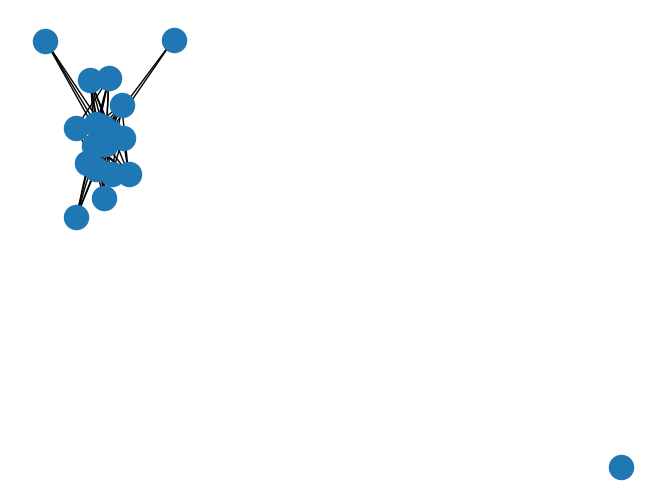

In [7]:
nx.draw(G)

In [8]:
# Get the edges of the graph with their weights
edges = G.edges(data=True)
edge_data = [(u, v, d['weight']) for u, v, d in edges]

# Create a DataFrame from the edge data
df = pd.DataFrame(edge_data, columns=['Origine_category', 'Job_category', 'Weight'])

# Save the DataFrame to a CSV file
df.to_csv('bipartite_graph.csv', index=False)

In [9]:
nx.write_gexf(G, "bipartite_origine_category_job_category.gexf")

In [10]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("./bipartite_graph.csv")

# Get unique division and job_category names
origine = df["Origine_category"].unique()
job_categories = df["Job_category"].unique()

# Create dictionaries to store nodes and links
nodes = []
links = []

# Iterate over divisions
for i, ori in enumerate(origine):
    # Add division node to nodes dictionary
    nodes.append({"Id": str(i), "label": str(ori), "type": "origine_category", "size": int(df[df["Origine_category"] == ori]["Weight"].sum())})
    
    # Iterate over job categories and add corresponding links
    for j, cat in enumerate(job_categories):
        weight = int(df[(df["Origine_category"] == ori) & (df["Job_category"] == cat)]["Weight"].sum())
        if weight > 0:
            links.append({"Source": str(i), "Target": str(cat), "Weight": weight})
            
# Iterate over job categories
for i, cat in enumerate(job_categories):
    # Add job category node to nodes dictionary
    nodes.append({"Id": str(cat), "label": str(cat), "type": "job_category", "size": int(df[df["Job_category"] == cat]["Weight"].sum())})
    
# Create JSON dictionary
json_dict = {"nodes": nodes, "links": links}

# Write JSON dictionary to file
with open("./bipartite_origine_category_type_metiers.json", "w") as f:
    json.dump(json_dict, f, indent=4)